In [164]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess

import arviz as az
import pymc as pm
import pytensor.tensor as at
import stan

In [165]:
import sys
sys.path.append('../') # go to parent dir
sys.path.append('/home/artem/git/sdafe-utils')

In [166]:
from sdafe.ch06.bootstrap import bootstrap
from sdafe.ch20.mcmc import gelman_diag_arviz, gelman_plot

In [167]:
import nest_asyncio
nest_asyncio.apply()

### 20.15.1 Fitting a t-Distribution by MCMC

In [168]:
data = pd.read_csv('../data/CRSPmon.csv')
data.head()

,ge,ibm,mobil,crsp
0,-0.011984,-0.059524,-0.014043,-0.006714
1,-0.060377,-0.007004,-0.078431,-0.053641
2,0.066474,0.070303,0.215130,0.030505
3,0.059621,0.044586,0.029961,0.020528
4,-0.035806,-0.025000,0.026667,0.005038


In [169]:
r = data['ibm']

In [170]:
with pm.Model() as model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=0, sigma=1000)
    tau = pm.Gamma('tau', 0.1, 0.01)
    k = pm.Uniform('k', 2, 50)
    sigma2 = 1 / tau
    sigma = pm.Deterministic('sigma', at.sqrt(sigma2))
    # Likelihood for the observed data
    r_ = pm.StudentT('r', nu=k, mu=mu, sigma=sigma, observed=r)

In [171]:
with model:
    idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, tau, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


#### Problem 1

In [172]:
az.summary(idata, var_names=['k', 'mu', 'sigma'], round_to=4, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,25.1891,11.7008,7.2195,47.0794,0.2773,0.2022,1689.2130,1842.6579,1.0002
mu,0.0094,0.0036,0.0020,0.0163,0.0001,0.0001,2542.6092,2163.7380,1.0037
sigma,0.0649,0.0031,0.0590,0.0713,0.0001,0.0001,1874.8357,1393.9667,0.9997


(a) Based on the effective sample size, `mu` mixes best. This is different from the result obtained via `jags` in R, where `sigma` has the highest $N_{\text{eff}}$.

(b) `sigma` mixes worst based on the results above. In R, `k` mixes worst.

(c) The 95% posterior interval for `k` is [6.8; 47.7].

In [173]:
var_names = ['k', 'mu', 'sigma']

In [10]:
s, mpsrf = gelman_diag_arviz(idata, var_names)
s

,Point est.,Upper C.I.
k,1.001030,1.003953
mu,1.000794,1.002766
sigma,1.000407,1.001702


In [11]:
mpsrf

1.0022198914359965

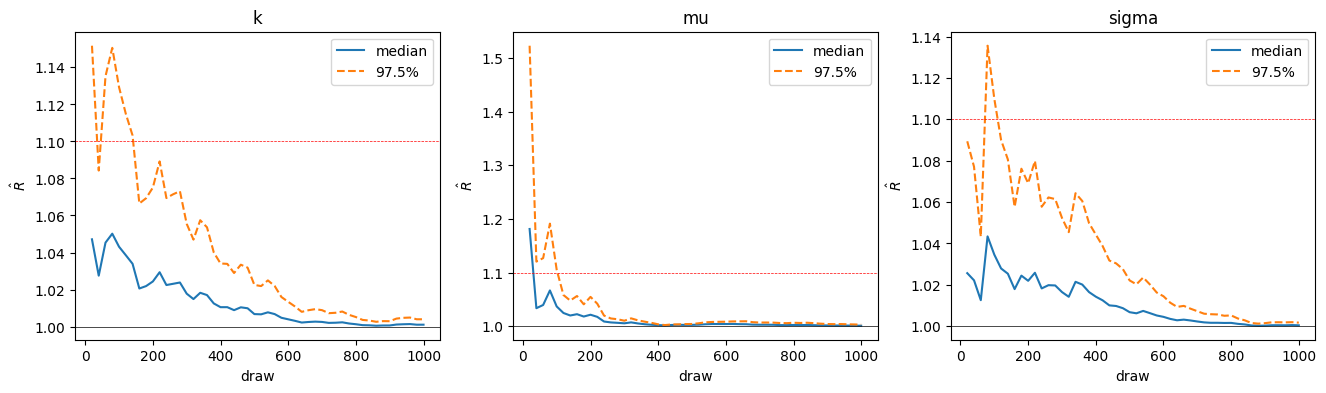

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
gelman_plot(fig, idata, var_names, guideline_level=1.1);

#### Problem 2

(a) `mu` appears to be mixing best whereas `k` and `sigma` mix worse based on autocorrelation plots:

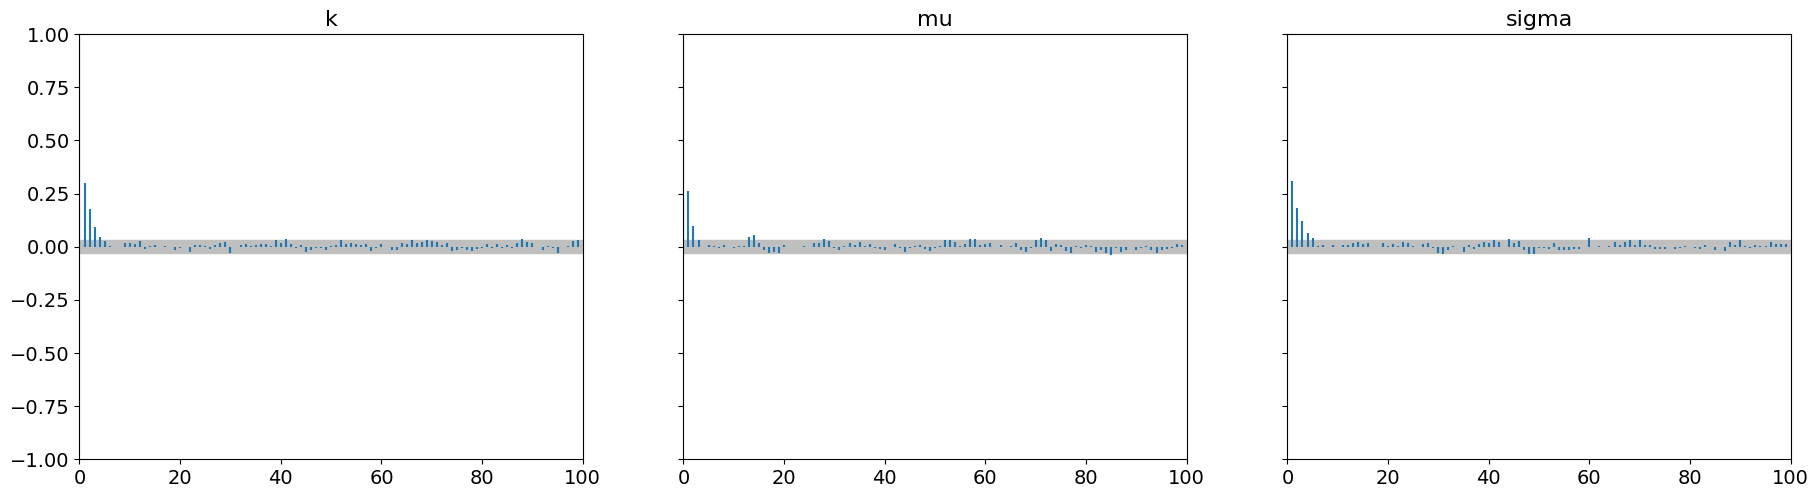

In [13]:
az.plot_autocorr(idata, var_names=var_names, combined=True);

(b) The posterior skewness of `k`:

In [14]:
stats.skew(idata.posterior['k'].values.flat)

0.34186953864288694

The posterior kurtosis of `k`:

In [15]:
stats.kurtosis(idata.posterior['k'].values.flat, fisher=False)

1.9850764140211443

#### Problem 3

The posterior density of `k` is most skewed:

/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


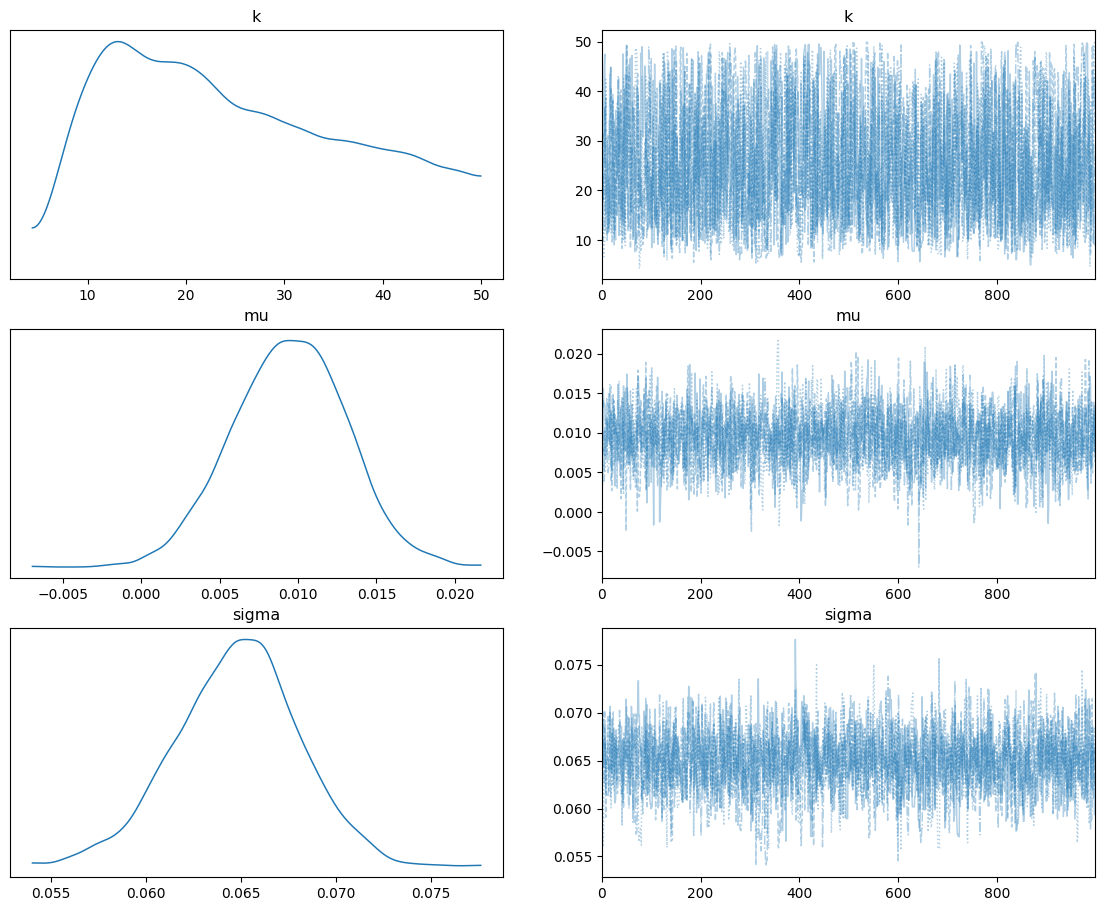

In [16]:
az.plot_trace(idata, var_names=var_names, combined=True, figsize=(14, 11));

#### Problem 4

In [17]:
def kurt_t(nu):
    return np.where(nu > 4, 3 * (nu - 2) / (nu - 4), np.inf)

In [18]:
kurt = kurt_t(idata.posterior['k'].values.flatten())

(a) The quantiles of the posterior distribution of the kurtosis are:

In [19]:
qs = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
pd.DataFrame(np.quantile(kurt, qs), index=qs, columns=['Quantile'])

,Quantile
0.01,3.132903
0.05,3.141238
0.25,3.193933
0.50,3.311862
0.75,3.548439
0.95,4.299772
0.99,5.240686


(b) The posterior probability that the kurtosis is finite:

In [20]:
np.sum(idata.posterior['k'].values.flat >= 4) / idata.posterior['k'].size

1.0

(c)

In [21]:
est = stats.kurtosis(r, fisher=False)
est

3.7062507701274297

For model-based bootstrap, we fit the t-distribution to the returns:

In [22]:
fit_t = stats.t.fit(r)
#fit_t = (round(fit_t[0]), *fit_t[1:])
fit_t

(12.15560055650331, 0.009090333330112098, 0.06205140167758731)

In [23]:
rng = np.random.default_rng(12345)

In [24]:
n_boot = 1000
estimator_fun = lambda xs: stats.kurtosis(xs, fisher=False)
model_free_kurt = bootstrap(r, lambda xs: rng.choice(xs, len(xs)), n_boot, estimator_fun)
model_based_kurt = bootstrap(r, lambda xs: stats.t.rvs(size=len(r), *fit_t), n_boot, estimator_fun)

In [25]:
def plot_with_kde(x, ax, title):
    ax.hist(x, bins=50, density=True, alpha=0.4, label=f'{title}')
    sns.kdeplot(x, ax=ax, label=title)

In [26]:
pd.DataFrame({
    ('MCMC', None): np.quantile(kurt, qs),
    ('Bootstrap', 'model-free'): np.quantile(model_free_kurt, qs),
    ('Bootstrap', 'model-based'): np.quantile(model_based_kurt, qs),
}, index=qs)

MCMC  Bootstrap            
           NaN model-free model-based
0.01  3.132903   2.761204    2.829869
0.05  3.141238   2.968438    2.971490
0.25  3.193933   3.355780    3.292783
0.50  3.311862   3.672031    3.573577
0.75  3.548439   3.993093    3.926517
0.95  4.299772   4.475733    4.928088
0.99  5.240686   4.760803    6.338439

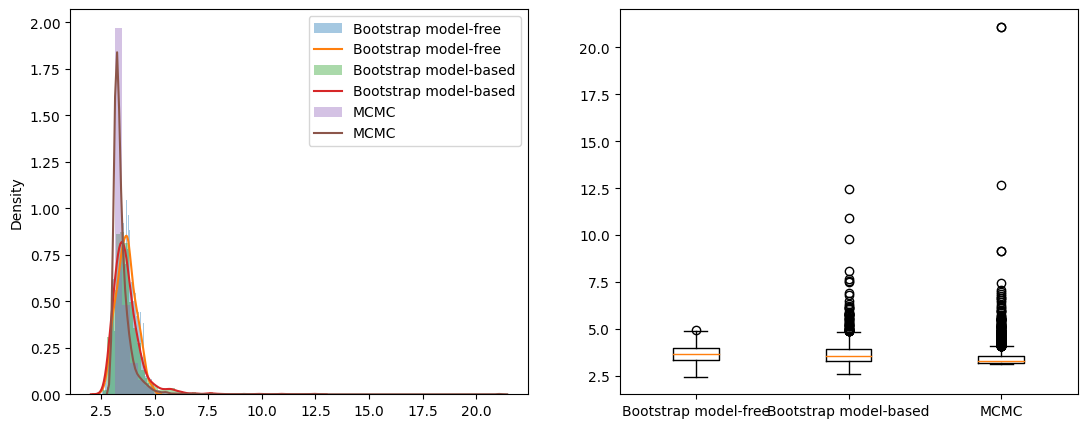

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

plot_with_kde(model_free_kurt, axs[0], 'Bootstrap model-free')
plot_with_kde(model_based_kurt, axs[0], 'Bootstrap model-based')
plot_with_kde(kurt, axs[0], 'MCMC')
axs[0].legend();

axs[1].boxplot([model_free_kurt, model_based_kurt, kurt], labels=['Bootstrap model-free', 'Bootstrap model-based', 'MCMC']);

The MCMC estimate appears to be smaller and more concentrated than either the model-free or model-based bootstrap estimates.

(d) The bootstrap (model-free) basic 90% confidence interval is:

In [28]:
conf = 0.9

In [29]:
2 * est - np.quantile(model_free_kurt, [(1 + conf) / 2, (1 - conf) / 2])

array([2.93676828, 4.4440634 ])

The 90% posterior interval for kurtosis:

In [30]:
np.quantile(kurt, [(1 - conf) / 2, (1 + conf) / 2])

array([3.14123821, 4.29977239])

We see that the posterior interval is narrower than the bootstrap interval. This is likely due to the fact that the posterior distribution of `k` is skewed, resulting in lower estimates of kurtosis.

### 20.15.2 AR Models

In [31]:
data = pd.read_csv('../data/Tbrate.csv')
# r = the 91-day treasury bill rate
# y = the log of real GDP
# pi = the inflation rate
data.head()

,r,y,pi
0,0.510,11.538320,0.50
1,0.510,11.538320,4.06
2,0.550,11.561030,5.50
3,0.623,11.601046,9.85
4,0.693,11.619265,14.00


In [32]:
y = data['y'].diff().dropna()

In [48]:
with pm.Model() as model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', 0, np.sqrt(10000))
    tau = pm.Gamma('tau', 0.1, 0.0001)
    phi = pm.Normal('phi', 0, np.sqrt(10000))
    sigma = pm.Deterministic('sigma', 1 / at.sqrt(tau))
    # Likelihood for the observed data
    y_ = y.iloc[0]
    for i in range(1, y.shape[0]):
        y_ = pm.Normal(f'y[{i}]', mu=mu + phi * (y_ - mu), sigma=sigma, observed=y.iloc[i])

In [49]:
with model:
    idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, tau, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [50]:
az.summary(idata, var_names=['mu', 'phi', 'sigma'], round_to=4, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.0097,0.0011,0.0075,0.0119,0.000,0.0000,5379.8592,3117.7124,1.0000
phi,0.2260,0.0723,0.0756,0.3599,0.001,0.0007,5202.7394,3075.6569,1.0004
sigma,0.0117,0.0006,0.0105,0.0129,0.000,0.0000,5073.7315,2875.4652,1.0004


In [51]:
var_names = ['mu', 'phi', 'sigma']

#### Problem 5

(a) Trace plots show reasonable mixing for all three parameters:

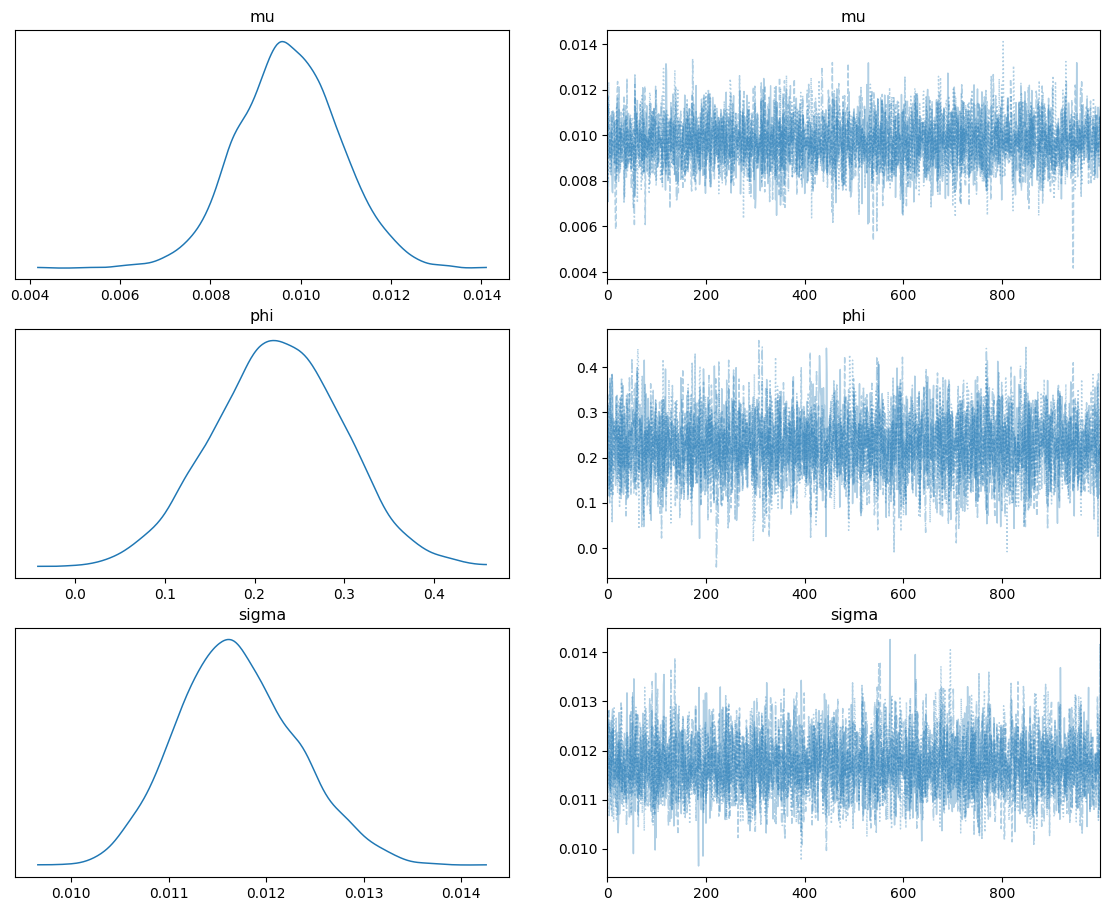

In [52]:
az.plot_trace(idata, var_names=var_names, combined=True, figsize=(14, 11));

The reported $\hat{R}$ values are also small, so we conclude that the number of draws is sufficient.

(b) The MLE estimates agree closely with MCMC estimates:

In [53]:
fit = sm.tsa.arima.ARIMA(y, order=(1, 0, 0)).fit(method='innovations_mle')
fit.summary()

/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 568.720
Date:                Thu, 11 May 2023   AIC                          -1131.440
Time:                        23:21:41   BIC                          -1121.747
Sample:                             0   HQIC                         -1127.513
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.001      8.883      0.000       0.008       0.012
ar.L1          0.2181      0.075      2.905      0.004       0.071       0.365
sigma2         0.0001   9.41e-06     14.201      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                61.34
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(c) In the model as formulated, the expectation of $Y_t$ is not constant, but depends on $t$.

Because
$$Y_t = \mu + \phi (Y_{t-1} - \mu) + \epsilon_t,$$
we have
$$E[Y_t] = \mu + \phi (E[Y_{t-1}] - \mu) = \mu + \phi^2 (E[Y_{t-2}] - \mu) = ... = \mu + \phi^t (Y_0 - \mu).$$

(d) In the stationary case, $E[Y_t] = \mu$, therefore we can modify the model to use $Y_0 \sim N(\mu, \sigma)$.

In [54]:
with pm.Model() as model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', 0, np.sqrt(10000))
    tau = pm.Gamma('tau', 0.1, 0.0001)
    phi = pm.Normal('phi', 0, np.sqrt(10000))
    sigma = pm.Deterministic('sigma', 1 / at.sqrt(tau))
    # Likelihood for the observed data
    y_ = pm.Normal('y[0]', mu=mu, sigma=sigma, observed=y.iloc[0])
    for i in range(1, y.shape[0]):
        y_ = pm.Normal(f'y[{i}]', mu=mu + phi * (y_ - mu), sigma=sigma, observed=y.iloc[i])

In [55]:
with model:
    idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, tau, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [56]:
az.summary(idata, var_names=['mu', 'phi', 'sigma'], round_to=4, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.0096,0.0011,0.0075,0.0118,0.000,0.0000,5526.0730,2997.1991,1.0017
phi,0.2241,0.0737,0.0709,0.3595,0.001,0.0007,5290.6034,3171.9142,1.0000
sigma,0.0117,0.0006,0.0106,0.0129,0.000,0.0000,6121.3076,3163.6086,1.0002


### 20.15.3 MA Models

In [65]:
rng = np.random.default_rng(12345)

In [66]:
N = 600

In [67]:
y = ArmaProcess(ma=[1, -0.5]).generate_sample(N, scale=0.4) + 3

In [68]:
q = 5

Attempting to sample from the model below using PyMC results in "RecursionError: maximum recursion depth exceeded":

In [71]:
with pm.Model() as model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', 0, 100)
    tau = pm.Gamma('tau', 0.01, 0.0001)
    theta = pm.Normal('theta', 0, 100)
    sigma = pm.Deterministic('sigma', 1 / at.sqrt(tau))

    # Likelihood for the observed data
    y_ = pm.Normal('y[0]', mu=mu, sigma=sigma, observed=y[0])
    w_ = pm.Normal('w[0]', 0, np.sqrt(10))
    for i in range(1, y.shape[0]):
        y_ = pm.Normal(f'y[{i}]', mu=mu + theta * w_, sigma=sigma, observed=y[i])
        w_ = y_ - mu - theta * w_
    
    for i in range(q):
        y_ = pm.Normal(f'ypred[{i}]', mu=mu + theta * w_, sigma=sigma)
        w_ = y_ - mu - theta * w_

In [103]:
model_ma = """
data {
  int<lower=0> T;
  vector[T] y;
  int<lower=0> q;
}
parameters {
  real mu;
  real<lower=0> tau;
  real<lower=-1, upper=1> theta;
  real w1;
}
transformed parameters {
  real<lower=0> sigma = 1 / sqrt(tau);
  vector[T] w;
  w[1] = w1;
  for (t in 2:T) {
    w[t] = y[t] - mu - theta * w[t-1];
  }
}
model {
  mu ~ normal(0, 100);
  theta ~ normal(0, 100);
  tau ~ gamma(0.01, 0.0001);
  w1 ~ normal(0, 10);
  for (t in 2:T) {
    y[t] ~ normal(mu + theta * w[t-1], sigma);
  }
}
generated quantities{
  vector[q] wpred;
  for (t in 1:q) {
    wpred[t] = normal_rng(0, sigma);
  } 
  vector[q] ypred;
  ypred[1] = mu + theta * w[T] + wpred[1];
  for (t in 2:q) {
    ypred[t] = mu + theta * wpred[t-1] + wpred[t];
  }
}
"""

In [104]:
data = {
    'y': y,
    'T': y.shape[0],
    'q': q,
}

In [105]:
posterior_ma = stan.build(model_ma, data=data);
fit_ma = posterior_ma.sample(num_chains=4, num_samples=1000)

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

In file included from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/artem/.cache/httpstan/4.10.0/models/ahfzlgbe/model_ahfzlgbe.cpp:2:
/home/artem/git/sdafe/.venv/lib/pyth

Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s


/home/artem/.cache/httpstan/4.10.0/models/ahfzlgbe/model_ahfzlgbe.cpp: In instantiation of ‘void model_ahfzlgbe_namespace::model_ahfzlgbe::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/artem/.cache/httpstan/4.10.0/models/ahfzlgbe/model_ahfzlgbe.cpp:533:50:   required from here
/home/artem/.cache/httpstan/4.10.0/models/ahfzlgbe/model_ahfzlgbe.cpp:360:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  360 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/artem/.cache/httpstan/4.10.0/models/ahfzlgbe/model_ahfzlgbe.cpp: In instantiation of ‘void model_ahfzlgbe_namespace::model_ahfzlgbe::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector

Building: 16.5s
Building: 16.6s


In file included from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/artem/.cache/httpstan/4.10.0/models/ahfzlgbe/model_ahfzlgbe.cpp:2:
/home/artem/git/sdafe/.venv/lib/pyth

Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building

Building: 41.5s, done.
Messages from stanc:
Warning in '/tmp/httpstan_hpaoa9qq/model_ahfzlgbe.stan', line 24, column 20: Argument
    0.0001 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_hpaoa9qq/model_ahfzlgbe.stan', line 24, column 14: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_hpaoa9qq/model_ahfzlgbe.stan', line 23, column 20: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_hpaoa9qq/model_ahfzlgbe.stan', line 22, column 17: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampl

In [106]:
idata = az.from_pystan(fit_ma)

#### Problem 6

(a) The shrink factor and trace plots indicate sufficient mixing, so we can assume the sample size is adequate:

In [139]:
var_names=['mu', 'theta', 'sigma', 'ypred']

In [140]:
az.summary(idata, var_names=var_names, round_to=6, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3.005669,0.008286,2.990089,3.022415,0.000135,0.000096,3790.344097,2789.246605,1.000796
theta,-0.498405,0.038398,-0.574035,-0.422312,0.000615,0.000435,3900.903723,2726.244721,1.000631
sigma,0.406200,0.011783,0.384556,0.429818,0.000179,0.000127,4347.925236,3064.646877,1.000166
ypred[0],2.872905,0.413037,2.026818,3.669764,0.006512,0.004605,4015.664017,3928.489674,0.999949
ypred[1],3.001607,0.456283,2.158592,3.922307,0.007351,0.005198,3856.923187,3737.913387,1.000003
ypred[2],3.002778,0.447364,2.149072,3.884886,0.007165,0.005074,3892.181590,3705.040292,1.000870
ypred[3],2.996856,0.454048,2.105585,3.880428,0.007104,0.005039,4087.460583,3513.028167,1.000914
ypred[4],3.004517,0.463484,2.095390,3.905462,0.007418,0.005245,3898.163746,3934.620956,1.001550


(b) Trace plots for `theta` and `sigma` show adequate mixing, although there are signs of autocorrelation in the plots:

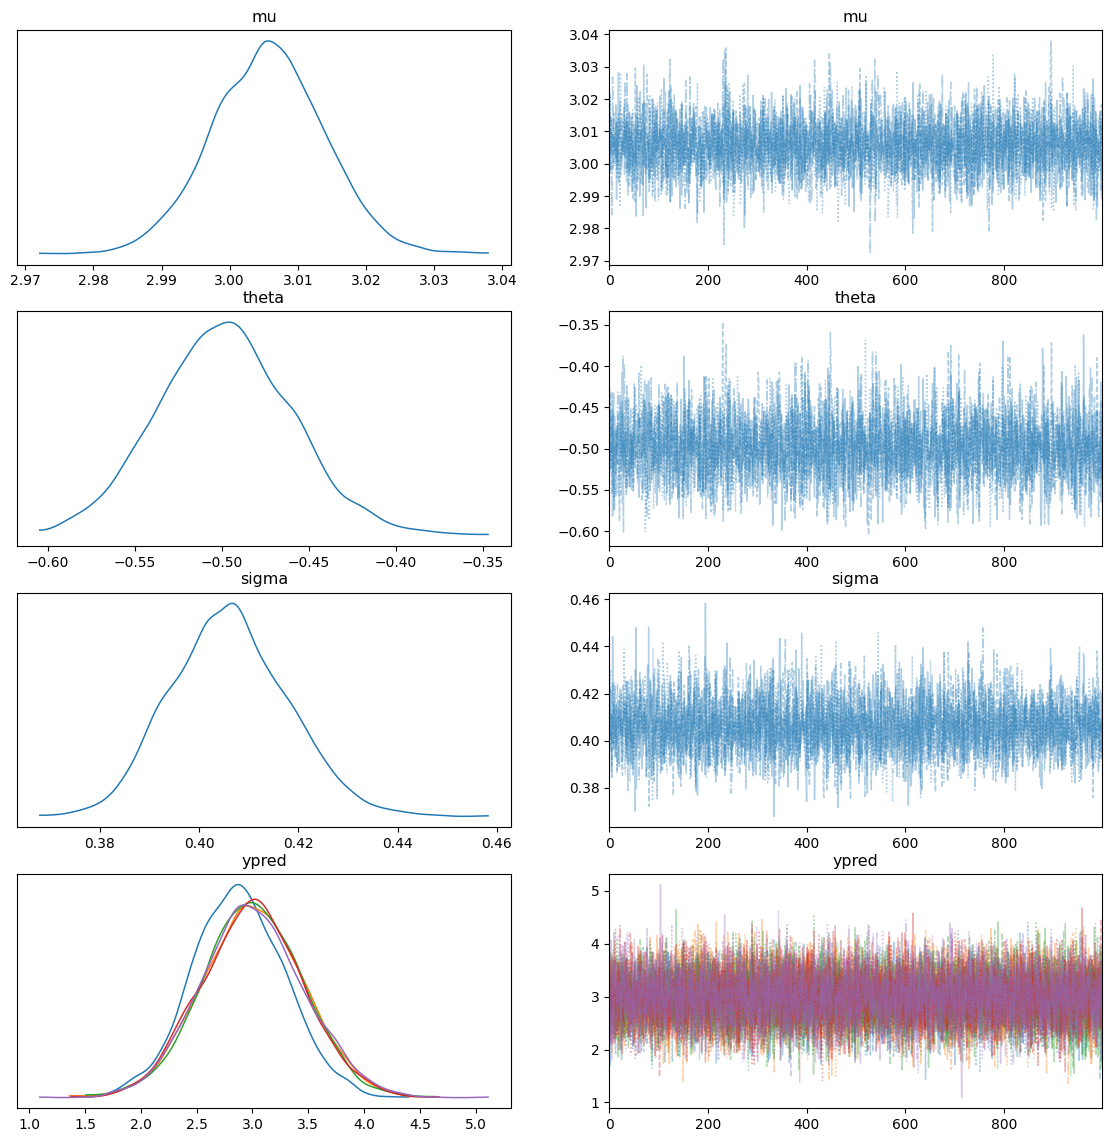

In [143]:
az.plot_trace(idata, var_names=var_names, combined=True, figsize=(14, 14));

Autocorrelation is more pronouced in the trace plots for predictions:

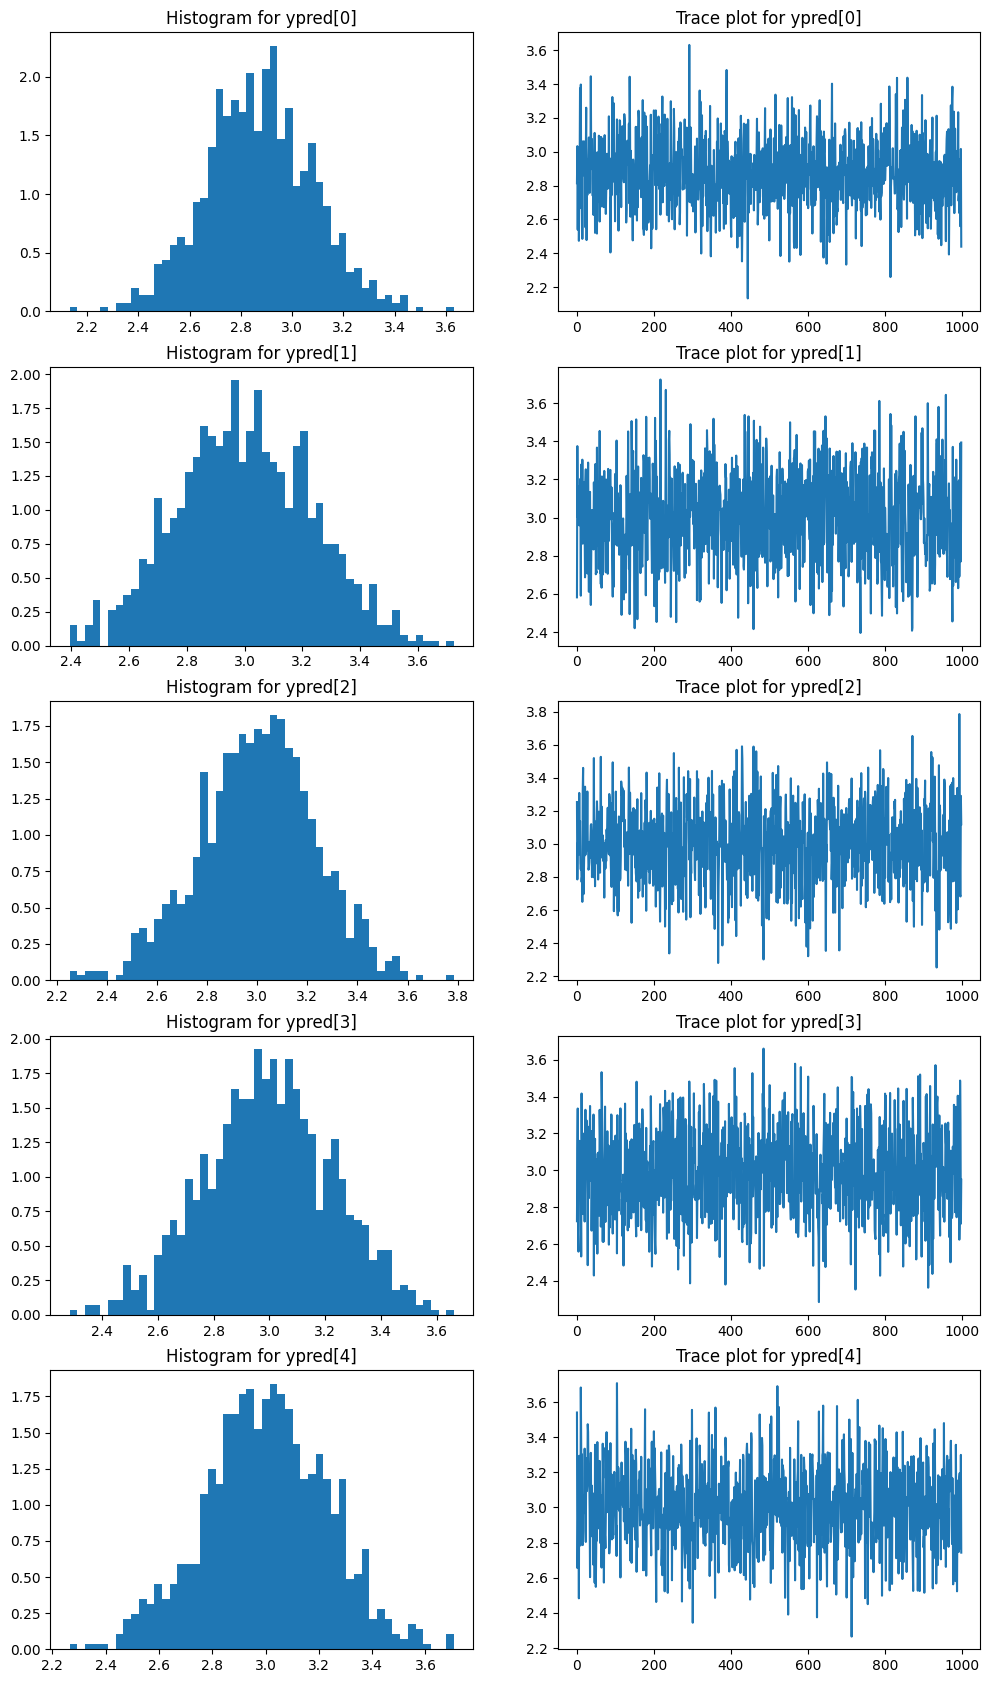

In [137]:
ypred = np.mean(idata.posterior['ypred'], axis=0)

fig, axs = plt.subplots(q, 2, figsize=(12, q * 4 + 1))

for i in range(q):
    axs[i][0].hist(ypred[:, i], density=True, bins=50);
    axs[i][0].set_title(f'Histogram for ypred[{i}]');

    axs[i][1].plot(ypred[:, i]);
    axs[i][1].set_title(f'Trace plot for ypred[{i}]');

The autocorrelations, however, are largely below the significance level:

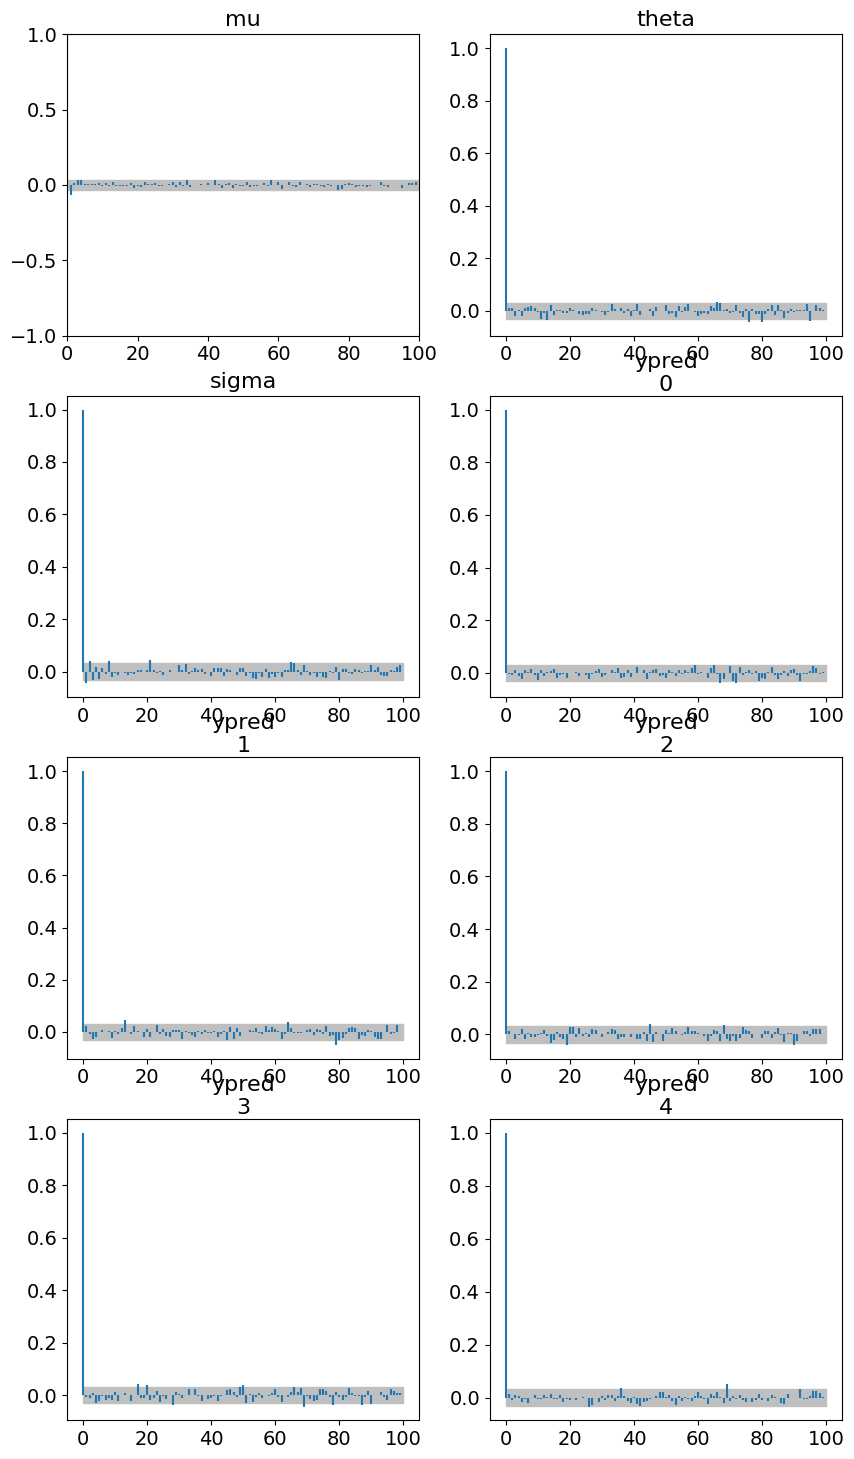

In [148]:
fig, axs = plt.subplots(4, 2, figsize=(10, 18))
az.plot_autocorr(idata, var_names=var_names, combined=True, ax=axs);

(c) The 90% posterior interval for the first predicted value:

In [151]:
conf = 0.9
np.quantile(idata.posterior['ypred'][:, :, 0].values.flat, [(1 - conf) / 2, (1 + conf) / 2])

array([2.20216525, 3.56101132])

### 20.15.4 ARMA Model

In [152]:
y = ArmaProcess(ar=[1, -0.9], ma=[1, -0.5]).generate_sample(N, scale=0.4)

In [156]:
model_arma = """
data {
  int<lower=0> T;
  vector[T] y;
}
parameters {
  real mu;
  real<lower=0> tau;
  real<lower=-1, upper=1> phi;
  real<lower=-1, upper=1> theta;
  real w1;
}
transformed parameters {
  real<lower=0> sigma = 1 / sqrt(tau);
  vector[T] w;
  w[1] = w1;
  for (t in 2:T) {
    w[t] = y[t] - (mu + phi * (y[t-1] - mu) + theta * w[t-1]);
  }
}
model {
  mu ~ normal(0, 100);
  theta ~ normal(0, 100);
  tau ~ gamma(0.01, 0.0001);
  w1 ~ normal(0, 10);
  for (t in 2:T) {
    y[t] ~ normal(mu + phi * (y[t-1] - mu) + theta * w[t-1], sigma);
  }
}
"""

In [157]:
data = {
    'y': y,
    'T': y.shape[0],
}

In [158]:
posterior_arma = stan.build(model_arma, data=data);
fit_arma = posterior_arma.sample(num_chains=4, num_samples=1000)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

In file included from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/artem/.cache/httpstan/4.10.0/models/2qbkpgbh/model_2qbkpgbh.cpp:2:
/home/artem/git/sdafe/.venv/lib/pyth

Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s


/home/artem/.cache/httpstan/4.10.0/models/2qbkpgbh/model_2qbkpgbh.cpp: In instantiation of ‘void model_2qbkpgbh_namespace::model_2qbkpgbh::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/artem/.cache/httpstan/4.10.0/models/2qbkpgbh/model_2qbkpgbh.cpp:477:50:   required from here
/home/artem/.cache/httpstan/4.10.0/models/2qbkpgbh/model_2qbkpgbh.cpp:327:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  327 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/artem/.cache/httpstan/4.10.0/models/2qbkpgbh/model_2qbkpgbh.cpp: In instantiation of ‘void model_2qbkpgbh_namespace::model_2qbkpgbh::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector

Building: 23.1s
Building: 23.2s


In file included from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/artem/.cache/httpstan/4.10.0/models/2qbkpgbh/model_2qbkpgbh.cpp:2:
/home/artem/git/sdafe/.venv/lib/pyth

Building: 23.3s
Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.0s


/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_

Building: 24.1s
Building: 24.2s
Building: 24.3s
Building: 24.4s
Building: 24.5s
Building: 24.7s
Building: 24.8s
Building: 24.9s
Building: 25.0s
Building: 25.1s
Building: 25.2s
Building: 25.3s
Building: 25.4s
Building: 25.5s
Building: 25.6s
Building: 25.7s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.1s
Building: 26.2s
Building: 26.3s
Building: 26.4s
Building: 26.5s
Building: 26.6s
Building: 26.7s
Building: 26.9s
Building: 27.0s
Building: 27.1s
Building: 27.2s
Building: 27.3s
Building: 27.4s
Building: 27.5s
Building: 27.6s
Building: 27.7s
Building: 27.8s
Building: 27.9s
Building: 28.0s
Building: 28.1s
Building: 28.2s
Building: 28.3s
Building: 28.4s
Building: 28.5s
Building: 28.6s
Building: 28.8s
Building: 28.9s
Building: 29.0s
Building: 29.1s
Building: 29.2s
Building: 29.3s
Building: 29.4s
Building: 29.5s
Building: 29.6s
Building: 29.7s
Building: 29.8s
Building: 29.9s
Building: 30.0s
Building: 30.1s
Building: 30.3s
Building: 30.4s
Building: 30.5s
Building: 30.6s
Building

Building: 41.6s, done.
Messages from stanc:
Warning in '/tmp/httpstan_3p3tlvf8/model_2qbkpgbh.stan', line 24, column 20: Argument
    0.0001 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_3p3tlvf8/model_2qbkpgbh.stan', line 24, column 14: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_3p3tlvf8/model_2qbkpgbh.stan', line 23, column 20: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_3p3tlvf8/model_2qbkpgbh.stan', line 22, column 17: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later

In [159]:
idata = az.from_pystan(fit_arma)

In [160]:
var_names = ['mu', 'phi', 'theta', 'sigma']

#### Problem 7

(a) Trace plots show adequate mixing for all four parameters:

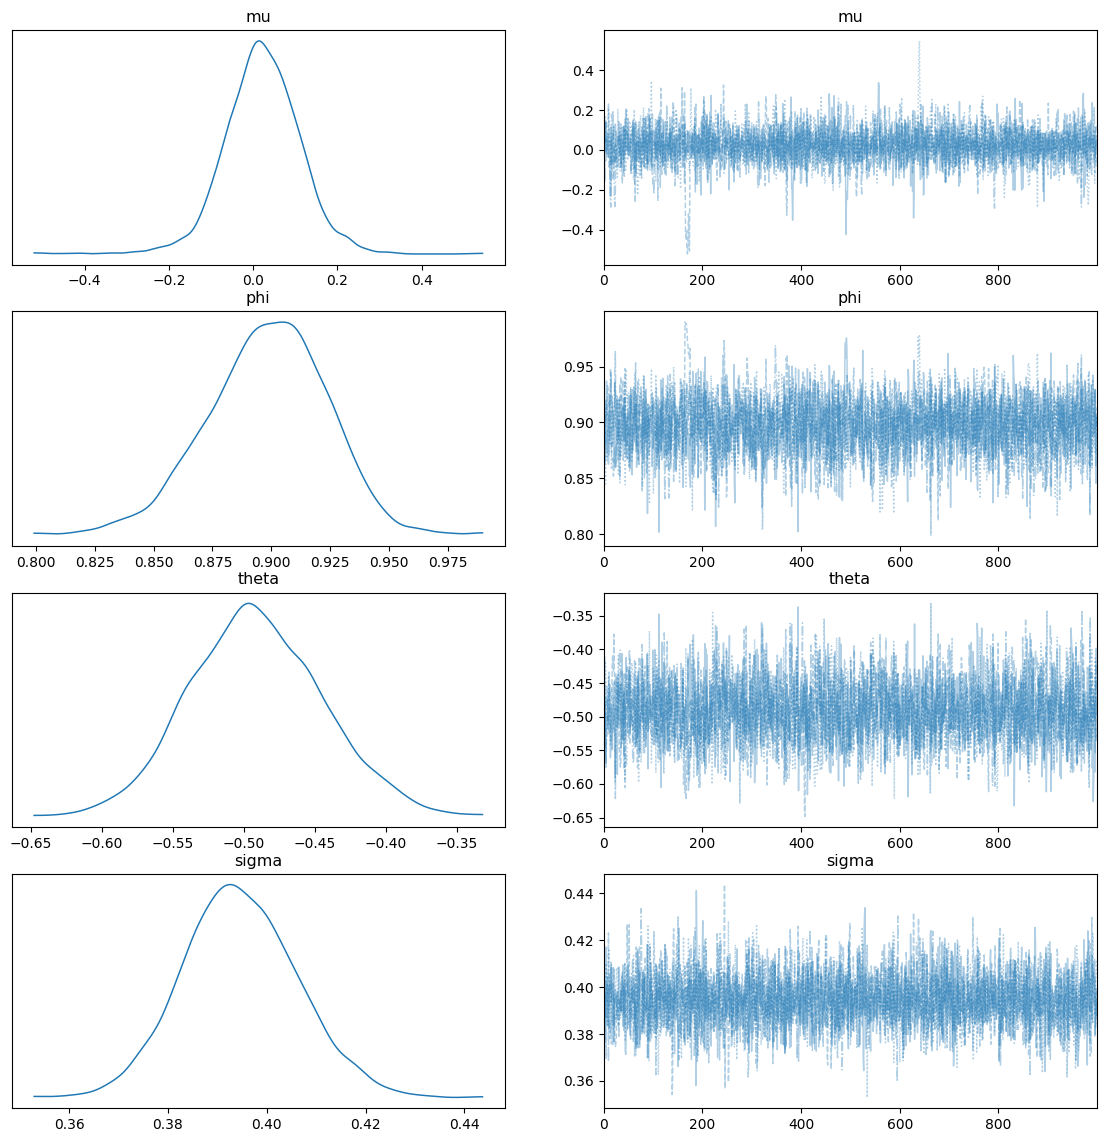

In [163]:
az.plot_trace(idata, var_names=var_names, combined=True, figsize=(14, 14));

(b) The 99% posterior intervals for the parameters are as follows:

In [162]:
az.summary(idata, var_names=var_names, round_to=6, hdi_prob=0.99)

,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.021929,0.090500,-0.237429,0.276497,0.001800,0.002087,3221.044013,2015.497011,1.001100
phi,0.898211,0.025498,0.827967,0.963643,0.000543,0.000388,2213.390512,1933.629050,1.001137
theta,-0.491695,0.046587,-0.611425,-0.375600,0.000893,0.000633,2723.683247,2710.822954,1.001796
sigma,0.394655,0.011586,0.365808,0.425626,0.000172,0.000122,4567.503350,2813.068245,1.001602
